Getting Started: Initialization of parameters

In [1]:
using HDF5, PyCall, PyPlot, Distributions, NLopt

path = "/Users/inchani/Desktop/UC\ Davis/My\ Courses/STA\ 250\ (AstroStatistics)/HW/HW2"
run(`head $path/wmap_lcdm_wmap9_chains_v5/omegach2`);
nlines = countlines("$path/wmap_lcdm_wmap9_chains_v5/omegach2");

nchain = 100_000
omega_b_chain     = readdlm("$path/wmap_lcdm_wmap9_chains_v5/omegabh2")[1:nchain,2]
omega_cdm_chain   = readdlm("$path/wmap_lcdm_wmap9_chains_v5/omegach2")[1:nchain,2]
tau_reio_chain    = readdlm("$path/wmap_lcdm_wmap9_chains_v5/tau")[1:nchain,2]
theta_s_chain     = readdlm("$path/wmap_lcdm_wmap9_chains_v5/thetastar")[1:nchain,2]
A_s_109_chain     = readdlm("$path/wmap_lcdm_wmap9_chains_v5/a002")[1:nchain,2]  # <-- 10⁹ * A_s
n_s_chain         = readdlm("$path/wmap_lcdm_wmap9_chains_v5/ns002")[1:nchain,2]

full_chain        = hcat(omega_b_chain, omega_cdm_chain, tau_reio_chain, theta_s_chain, A_s_109_chain, n_s_chain);
wmap_chain        = copy(full_chain)
names_chain       = [:omega_b, :omega_cdm, :tau_reio, :theta_s, :A_s_109, :n_s];

const σ² = (10.0/3437.75)^2;    # <---10μkarcmin noise level converted to radian pixels (1 radian = 3437.75 arcmin)
const b² = (0.0035)^2;          # <-- pixel width 0.2ᵒ ≈ 12.0 armin ≈ 0.0035 radians          

const Σwmap             = cov(full_chain);
const bandpowers = h5read("$path/bandpowers.h5", "bandpowers");

const lcdm_sim_truth = h5read("$path/lcdm_sim_truth.h5", "lcdm_sim_truth")
@pyimport pypico
const picoload = pypico.load_pico("$path/pico3_tailmonty_v34.dat")


wmap_best_fit = vec(mean(full_chain,1))
[names_chain wmap_best_fit]

1       0.117062874352432095
2       0.108967379062375080
3       0.109528409355401521
4       0.101409184716838671
5       0.104083078229435091
6       0.107187006794221051
7       0.112446837434475005
8       0.107616613742339856
9       0.111562053244599030
10      0.111868995879391156


6x2 Array{Any,2}:
 :omega_b    0.022635 
 :omega_cdm  0.113854 
 :tau_reio   0.0889852
 :theta_s    0.0103905
 :A_s_109    2.41154  
 :n_s        0.972309 

PICO

In [2]:
function pico(x::Array{Float64,1})     
    omega_b     = x[1]
    omega_cdm   = x[2]
    tau_reio    = x[3]
    theta_s     = x[4]
    A_s_109     = x[5]
    n_s         = x[6]
    plout::Dict{ASCIIString, Array{Float64,1}} = picoload[:get](;
        :re_optical_depth => tau_reio,
        symbol("scalar_amp(1)") =>  1e-9*A_s_109,
        :theta => theta_s,
        :ombh2 => omega_b,
        :omch2 => omega_cdm,
        symbol("scalar_spectral_index(1)") => n_s,
        :massive_neutrinos => 3.04,
        :helium_fraction => 0.25,
        :omnuh2 => 0.0,
        symbol("scalar_nrun(1)") => 0.0,
        :force     => true
    )
    clTT::Array{Float64,1} = plout["cl_TT"]
    ells   = 0:length(clTT)-1
    clTT .*= 2π ./ ells ./ (ells + 1)
    clTT[1] = 0.0
    return clTT
end

pico (generic function with 1 method)

Defining Log likelihood of posterior and proposal. 
Since my choice of proposal is symmetric, I will ignore it. 

In [3]:
function LogPost(θ::Array{Float64,1})
    ClTT = pico(θ)
    ell  = 0:length(ClTT)-1
    Cldd = ClTT + σ² * exp(b² .* ell .* (ell + 1) ./ (8log(2)))
    rtn = 0.0
    @inbounds for l in ell[2:end]    # change 2 -> 3,  l=1 "dipole"
      rtn -= log(Cldd[l+1]) * (2l+1) / 2
      rtn -= (bandpowers[l+1] / Cldd[l+1]) * (2l+1) / 2
    end
    return rtn
end


function Pprop(θ1::Array{Float64,1},θ2::Array{Float64,1})
    d = length(θ1)
    return exp(-0.5 .* transpose(θ1-θ2) * (Σwmap\ (θ1-θ2))) ./ √( (2π)^d * det(Σwmap))
end
   

Pprop (generic function with 1 method)

In [4]:
llmin(x,grad)  = LogPost(x)
algm = [:LN_BOBYQA, :LN_COBYLA, :LN_PRAXIS, :LN_NELDERMEAD, :LN_SBPLX]
opt = Opt(algm[1], 6)
upper_bounds!(opt, [0.034, 0.2,  0.55,  .0108, exp(4.0)/10,  1.25])
lower_bounds!(opt, [0.018, 0.06, 0.01,  .0102, exp(2.75)/10, 0.85])  # <-- pico training bounds
maxtime!(opt, 5*60.0)   # <--- max time in seconds
max_objective!(opt, llmin)
optf, optx, ret = optimize(opt, wmap_best_fit)

pypico.datafiles.3e624ff23f85df8ba6355a4e18135245:326: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
pypico.datafiles.3e624ff23f85df8ba6355a4e18135245:116: RuntimeWarning: divide by zero encountered in divide


(-3.896796090452089e8,[0.02247874726318284,0.10811925892802669,0.0780899335694353,0.010400367948677961,2.2581318865051263,0.9794888952065252],:ROUNDOFF_LIMITED)

In [5]:
hcat(names_chain, optx, lcdm_sim_truth, wmap_best_fit)

6x4 Array{Any,2}:
 :omega_b    0.0224787  0.0223805  0.022635 
 :omega_cdm  0.108119   0.109353   0.113854 
 :tau_reio   0.0780899  0.0759736  0.0889852
 :theta_s    0.0104004  0.0104023  0.0103905
 :A_s_109    2.25813    2.28102    2.41154  
 :n_s        0.979489   0.976015   0.972309 

In [6]:
@show llmin(optx, 0) - llmin(lcdm_sim_truth, 0);
@show llmin(optx, 0) - llmin(wmap_best_fit, 0);

llmin(optx,0) - llmin(lcdm_sim_truth,0) = 0.9888594150543213
llmin(optx,0) - llmin(wmap_best_fit,0) = 61.63154602050781


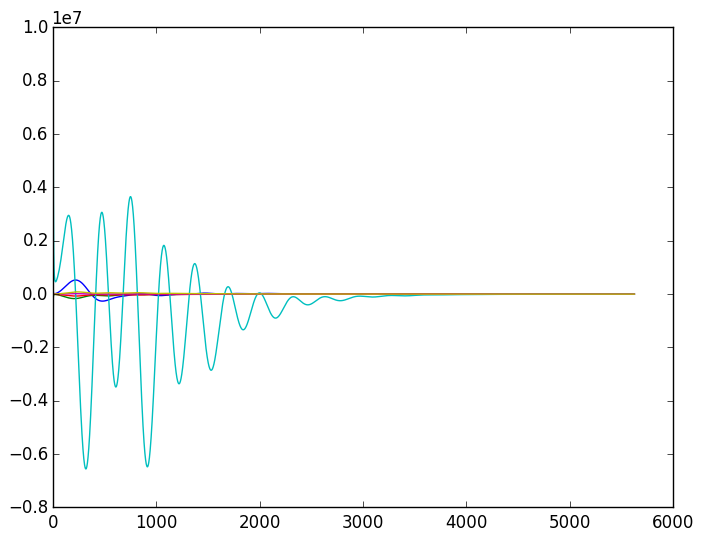

6-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x307a17490>
 PyObject <matplotlib.lines.Line2D object at 0x307a17610>
 PyObject <matplotlib.lines.Line2D object at 0x307a17790>
 PyObject <matplotlib.lines.Line2D object at 0x307a17910>
 PyObject <matplotlib.lines.Line2D object at 0x307a17a90>
 PyObject <matplotlib.lines.Line2D object at 0x307a17c10>

In [7]:
dϵ = 1e-12
v  = zeros(6)
v[1] = 1
X = zeros(length(bandpowers),6)
for i = 1:6
    X[:,i]   = (pico(optx + dϵ*circshift(v,i-1)) - pico(optx))/dϵ
end
plot(collect((1:length(bandpowers))).^2 .* X)

In [8]:
ell = collect(0:length(bandpowers)-1)
cldd = pico(optx) + σ² * exp(b² .* ell .* (ell + 1) ./ (8log(2)))
Σinv = inv(X' * diagm(1 ./ ( (2./(2*ell+1)) .* cldd.^2)) * X)

6x6 Array{Float64,2}:
  4.61507e-8   -3.08577e-7   4.11336e-6   …   1.08457e-5   8.43693e-7 
 -3.08577e-7    4.12442e-6  -4.2532e-5       -9.08564e-5  -1.07704e-5 
  4.11336e-6   -4.2532e-5    0.00113375       0.00399697   0.000121211
  5.33714e-10  -5.17415e-9   5.7713e-8        1.24148e-7   1.52563e-8 
  1.08457e-5   -9.08564e-5   0.00399697       0.0157949    0.00024258 
  8.43693e-7   -1.07704e-5   0.000121211  …   0.00024258   3.31675e-5 

Initial guess of LCDM params

In [9]:
θ₀ = [0.022635 , 0.113854 , 0.0889852, 0.0103905, 2.41154, 0.972309 ];

Metropolis–Hastings chain

In [10]:
function MH(θ₀::Array{Float64,1}, Σinv::Array{Float64,2}, g::Float64, N::Int64, NThin::Int64, NBurn::Int64)
    const lcdm_proposal_RV = MultivariateNormal(zeros(6), g*Σinv)
    generate_lcdm_prop(lcdm_curr)  = rand(lcdm_proposal_RV) + lcdm_curr
    
    d      = length(θ₀)
    θcurr  = copy(θ₀)
    LogPostCurr = LogPost(θcurr)
    θprop  = 0.
    acceptance = 0.
    α, u = 0., 0.
    θ      = Array(Float64, N*NThin, d)
    αhist  = Array(Float64, N*NThin)    
    uhist  = Array(Float64, N*NThin)    
    
    println("start burn-in")
    for i=1:NBurn
        θprop  = copy(generate_lcdm_prop(θcurr))
        u = log(rand())
        LogPostProp = LogPost(θprop)
        α = min( LogPostProp - LogPostCurr, 0.) 
        if u <= α
            θcurr       = copy(θprop)
            LogPostCurr = copy(LogPostProp)
        end
    end
        
    println("start MCMC chain")
    percent  = 0.
    for i = 1:N*NThin
        θprop  = copy(generate_lcdm_prop(θcurr))
        u = log(rand())
        LogPostProp = LogPost(θprop)
        α = min( LogPostProp - LogPostCurr, 0.) 
        if u <= α
            θcurr  = copy(θprop)
            LogPostCurr = copy(LogPostProp)
        end

        θ[i,:]   = copy(θcurr[:])
        αhist[i] = copy(exp(α))
        uhist[i] = copy(u)
        
        if i ./ (N*NThin).* 100 > percent
            P_accept = αhist[i]
            println("$percent percent is done. accecptance rate is : $P_accept")
            percent += 5.
        end
    end
    println("MCMC chain is finished.")
    return αhist[NThin:NThin:end], uhist[NThin:NThin:end], θ[NThin:NThin:end,:]
end

MH (generic function with 1 method)

Correlation function

In [11]:
function Autocorrelation(x::Array{Float64,1})
    dim = length(x)
    ρ   = Array(Float64, dim) 
    for i=1:dim
        rtn = 0.
        for j = i+1:dim
            if j > i 
                rtn += x[j] .* x[j-i]
            else
                rtn += x[j] .* x[j-i+dim]
            end
        end
        ρ[i] = copy(rtn ./ (dim-1))
    end
    return ρ
end

Autocorrelation (generic function with 1 method)

In [12]:
g = 0.2
dim = 400
Nthin = 20
Nburn = 100
@time αhist, uhist, θChain = MH(θ₀,Σinv,g,dim,Nthin,Nburn);

start burn-in
start MCMC chain
0.0 percent is done. accecptance rate is : 0.8231569021023346
5.0 percent is done. accecptance rate is : 0.4266077417504983
10.0 percent is done. accecptance rate is : 0.9979715682250717
15.0 percent is done. accecptance rate is : 4.201976673324902e-9
20.0 percent is done. accecptance rate is : 0.01910101786945135
25.0 percent is done. accecptance rate is : 1.0
30.0 percent is done. accecptance rate is : 1.0
35.0 percent is done. accecptance rate is : 1.0
40.0 percent is done. accecptance rate is : 2.4277733016556415e-6
45.0 percent is done. accecptance rate is : 0.2374111533184644
50.0 percent is done. accecptance rate is : 1.0
55.0 percent is done. accecptance rate is : 6.714422630355866e-9
60.0 percent is done. accecptance rate is : 0.29870418468805693
65.0 percent is done. accecptance rate is : 0.16781985152964674
70.0 percent is done. accecptance rate is : 1.0
75.0 percent is done. accecptance rate is : 0.16897531839184454
80.0 percent is done. accec

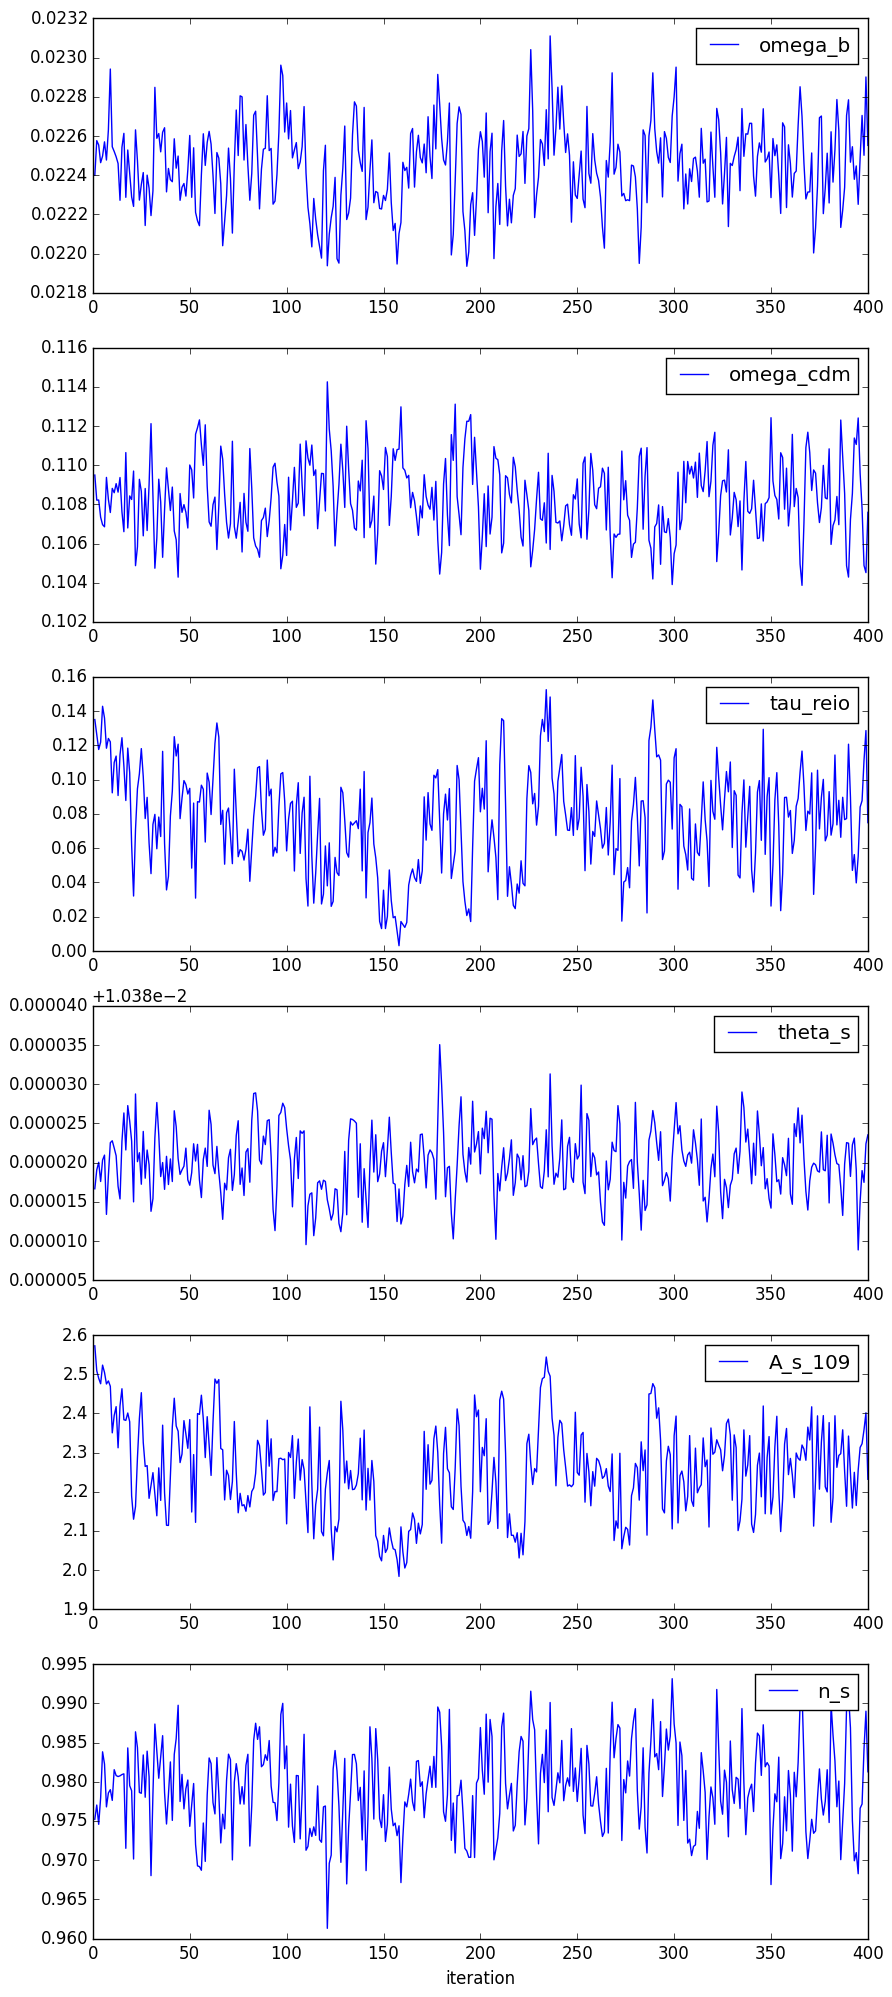

PyObject <matplotlib.legend.Legend object at 0x31a9f0650>

In [13]:
μα = round(mean((αhist))*100.) * 0.01
μu = round(mean((uhist))*100.) * 0.01

x = linspace(1, length(αhist), length(αhist));
figure(figsize=(10,24));
i = 1
subplot(6,1,i)
plot(x,θChain[:,i], label = names_chain[i])
legend()

i +=1
subplot(6,1,i)
plot(x,θChain[:,i], label = names_chain[i])
legend()

i +=1
subplot(6,1,i)
plot(x,θChain[:,i], label = names_chain[i])
legend()

i +=1
subplot(6,1,i)
plot(x,θChain[:,i], label = names_chain[i])
legend()

i +=1
subplot(6,1,i)
plot(x,θChain[:,i], label = names_chain[i])
legend()

i +=1
subplot(6,1,i)
plot(x,θChain[:,i], label = names_chain[i])
legend()
xlabel("iteration")
legend()

Correlation Function

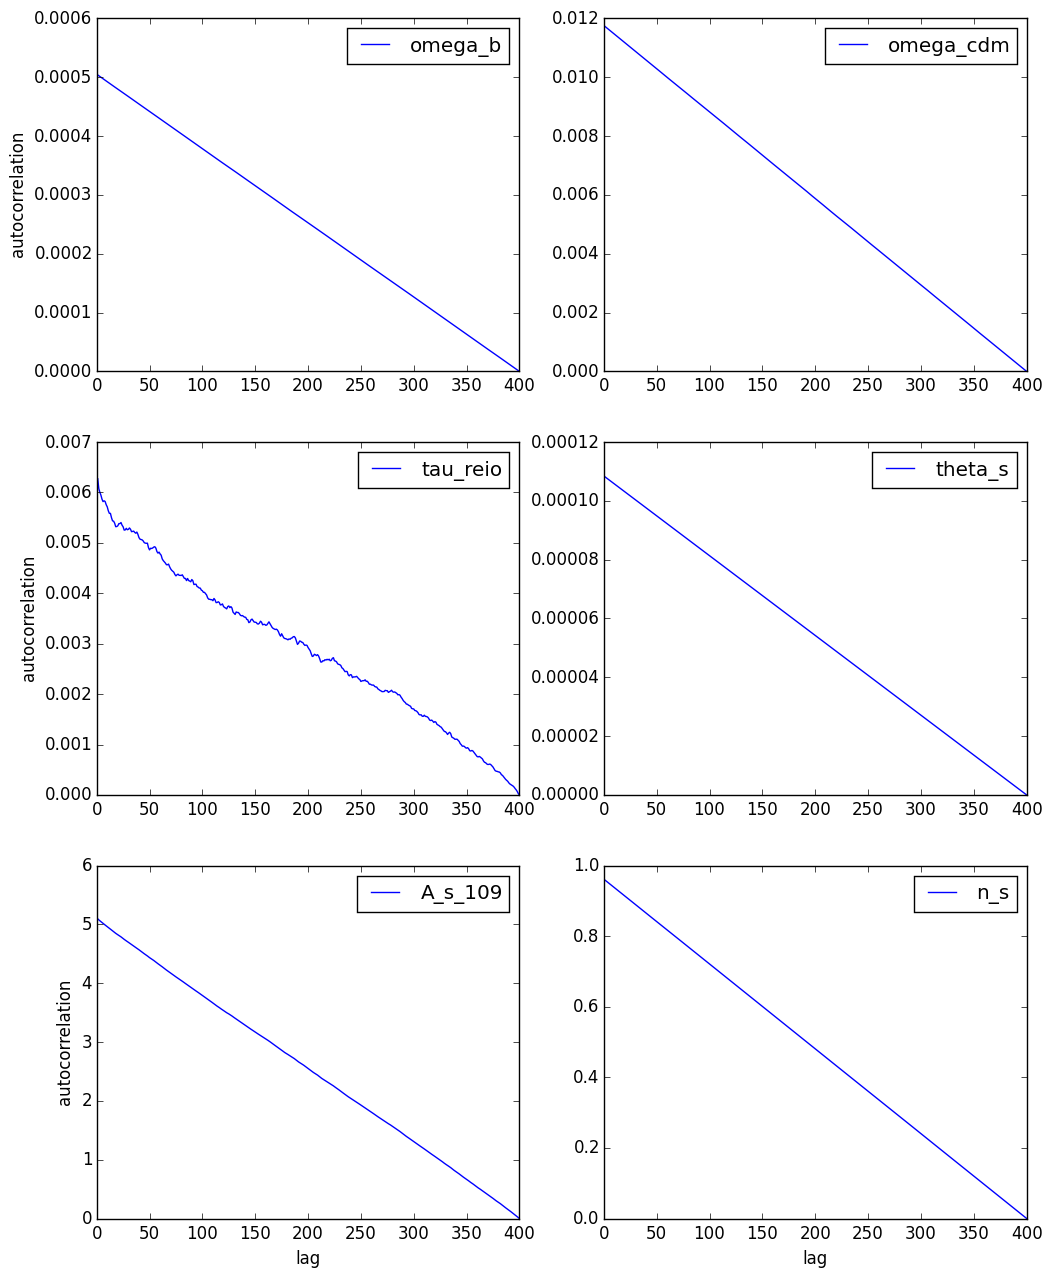

PyObject <matplotlib.legend.Legend object at 0x31d84c450>

In [14]:
figure(figsize=(12,15));

i = 1
subplot(3,2,i)
plot(x,Autocorrelation(θChain[:,i]), label = names_chain[i])
ylabel("autocorrelation")
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain[:,i]), label = names_chain[i])
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain[:,i]), label = names_chain[i])
ylabel("autocorrelation")
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain[:,i]), label = names_chain[i])
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain[:,i]), label = names_chain[i])
ylabel("autocorrelation")
xlabel("lag")
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain[:,i]), label = names_chain[i])
xlabel("lag")
legend()


/Users/inchani/python/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


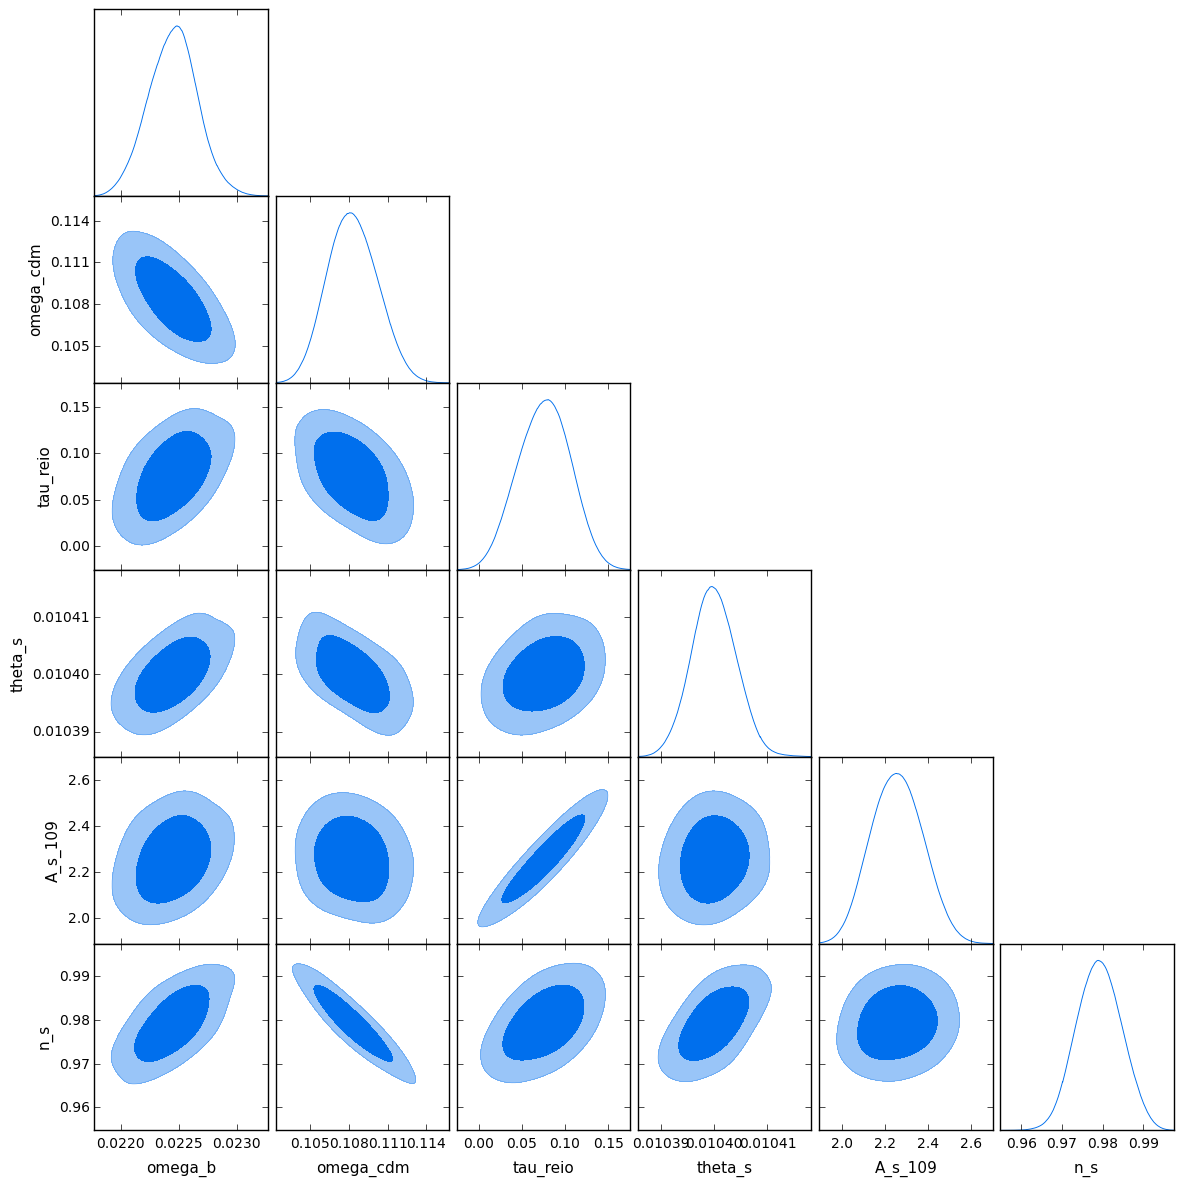

/Users/inchani/python/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [15]:
names_chain   = [:omega_b, :omega_cdm, :tau_reio, :theta_s, :A_s_109, :n_s]
full_chain    = θChain
@pyimport getdist
@pyimport getdist.plots as plots
samples = getdist.MCSamples(samples=full_chain, names=names_chain)
g = plots.getSubplotPlotter()
g[:triangle_plot](samples, filled=true)

Choosing walkers (I'm not sure if it is ok to use g-prior (g=1) for walkers )

In [40]:
Nwalkers = 50
walkers = Array(Float64, Nwalkers, 6)
for i = 1:Nwalkers
    walkers[i,:] = copy(optx) + rand(MultivariateNormal(zeros(6), Σinv))
end
#scatter(walkers[:,1],walkers[:,2])
#grid()

Affine-Invariant chain

In [26]:
function AI(walkers::Array{Float64,2}, a::Float64, N::Int64, NThin::Int64)
    
    Nwalkers = length(walkers[:,1])
    Ntot   = N*Nwalkers
    d      = length(walkers[1,:])
    θ      = Array(Float64, Nwalkers+Ntot, d)
    αhist  = Array(Float64, Nwalkers+Ntot)    
    uhist  = Array(Float64, Nwalkers+Ntot) 
    LogPostWalkers = Array(Float64, Nwalkers)
    θ₀ = Array(Float64, d)
    θprop = Array(Float64, d)

    k = 1
    
    println("start MCMC chain") 
    θ[1:Nwalkers,:] = copy(walkers)    
    for i = 1:N
        walkers  = copy(θ[k:k+Nwalkers-1,:])
        θ[Nwalkers+k:Nwalkers*2+k-1,:] = copy(walkers)
        
        for i=1:Nwalkers
            θ₀[:] = copy(walkers[i,:])
            LogPostWalkers[i] = LogPost(θ₀)
        end
        
        for j = 1:Nwalkers
            z = ((√a - 1/√a) * rand() + 1/√a)^2     #  prop to 1/√z
            ind = rand(1:Nwalkers-1)
            if j >= ind 
                ind += 1
            end
            
            θprop = copy(walkers[ind,:] + z .* (walkers[j,:] - walkers[ind,:]))[:]
            
            u = log(rand())
            LogPostProp = LogPost(θprop)
            α = min( (d-1.)*log(z) + LogPostProp - LogPostWalkers[j], 0.)
            
            if u <= α
                θ[Nwalkers+k,:] = copy(θprop)[:]
            end
            αhist[Nwalkers+k] = copy(exp(α))
            uhist[Nwalkers+k] = copy(exp(u))
            
            k += 1      
        end
        P_accept = αhist[Nwalkers+k-1]
        println("accecptance rate is : $P_accept  ($k /$Ntot)")

        
    end
    println("MCMC chain is finished.")    
    return αhist[Nwalkers:NThin:end], uhist[Nwalkers:NThin:end], θ[Nwalkers:NThin:end,:]
end

AI (generic function with 1 method)

In [35]:
a = 2.
dim = 8
Nthin = 3
@time αhist, uhist, θChain2 = AI(walkers,a,dim,Nthin);

start MCMC chain
accecptance rate is : 0.09355820713252741  (51 /400)
accecptance rate is : 1.0  (101 /400)
accecptance rate is : 1.0  (151 /400)
accecptance rate is : 0.8571223832945282  (201 /400)
accecptance rate is : 0.1635177856647745  (251 /400)
accecptance rate is : 0.5379955153857876  (301 /400)
accecptance rate is : 0.01143066555558412  (351 /400)
accecptance rate is : 0.026947324139298717  (401 /400)
MCMC chain is finished.
122.172948 seconds (1.45 M allocations: 779.735 MB, 0.30% gc time)


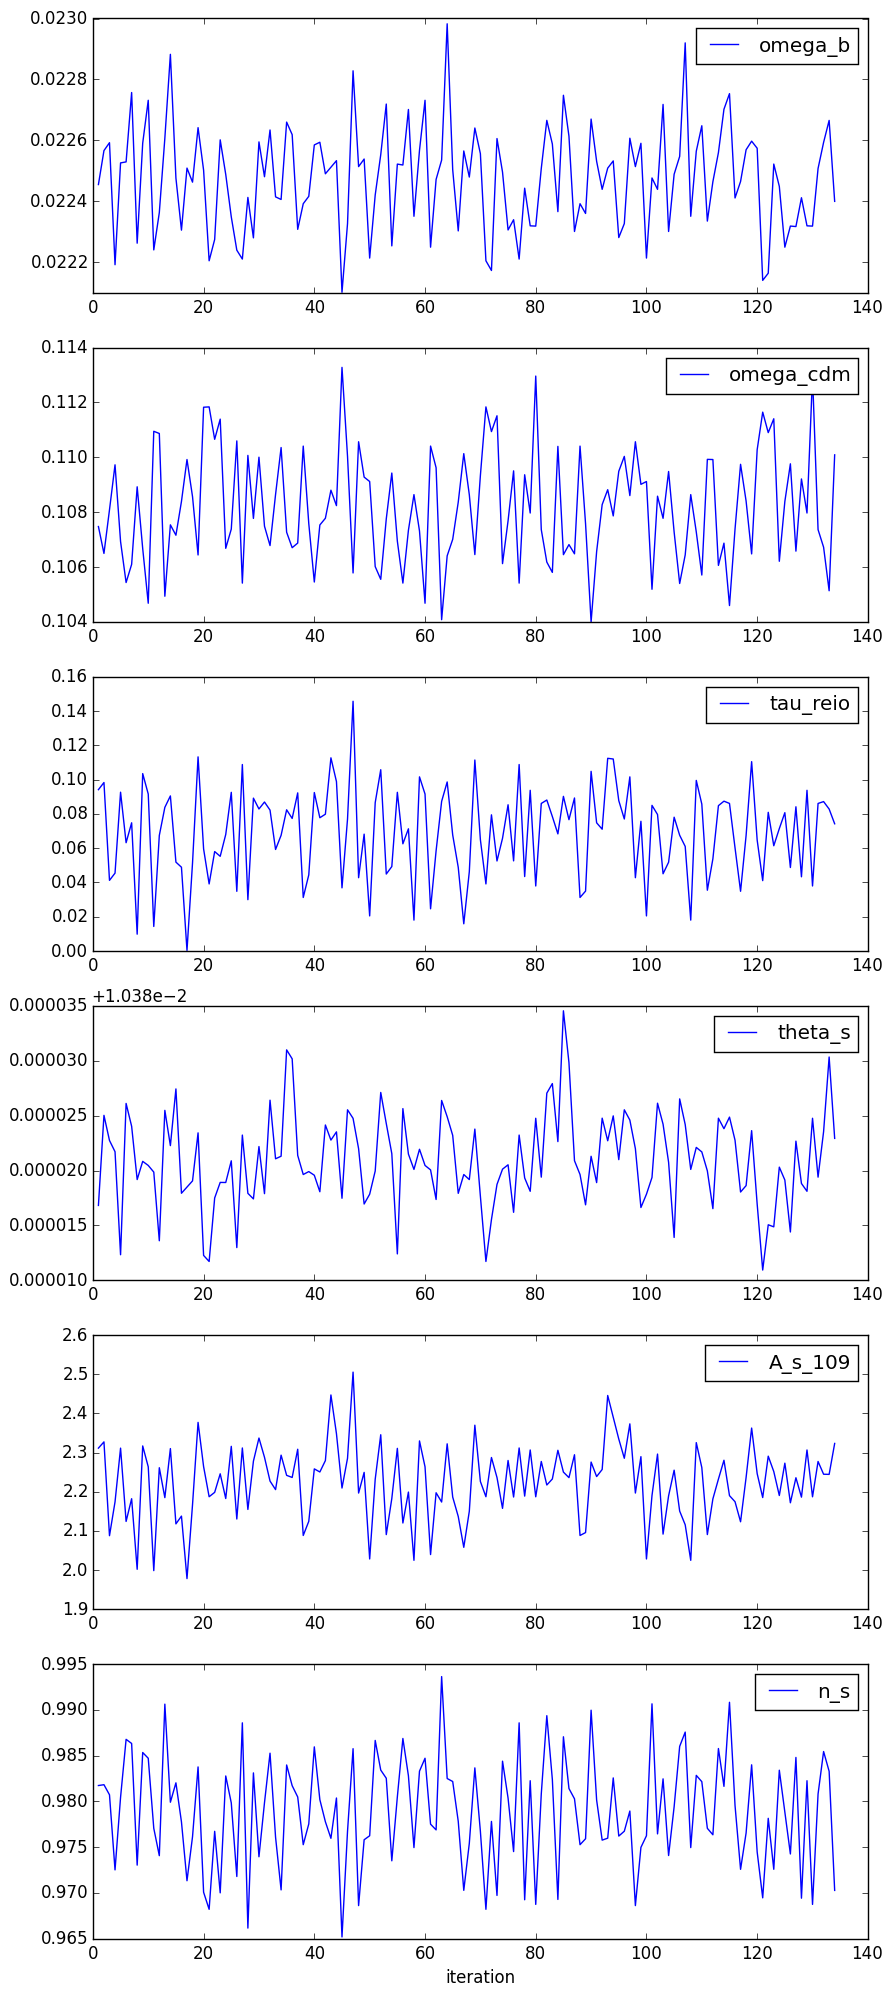

PyObject <matplotlib.legend.Legend object at 0x341593090>

In [36]:
μα = round(mean((αhist))*100.) * 0.01
μu = round(mean((uhist))*100.) * 0.01

x = linspace(1, length(αhist), length(αhist));
figure(figsize=(10,24));
i = 1
subplot(6,1,i)
plot(x,θChain2[:,i], label = names_chain[i])
legend()

i +=1
subplot(6,1,i)
plot(x,θChain2[:,i], label = names_chain[i])
legend()

i +=1
subplot(6,1,i)
plot(x,θChain2[:,i], label = names_chain[i])
legend()

i +=1
subplot(6,1,i)
plot(x,θChain2[:,i], label = names_chain[i])
legend()

i +=1
subplot(6,1,i)
plot(x,θChain2[:,i], label = names_chain[i])
legend()

i +=1
subplot(6,1,i)
plot(x,θChain2[:,i], label = names_chain[i])
legend()
xlabel("iteration")
legend()

Correlation Function

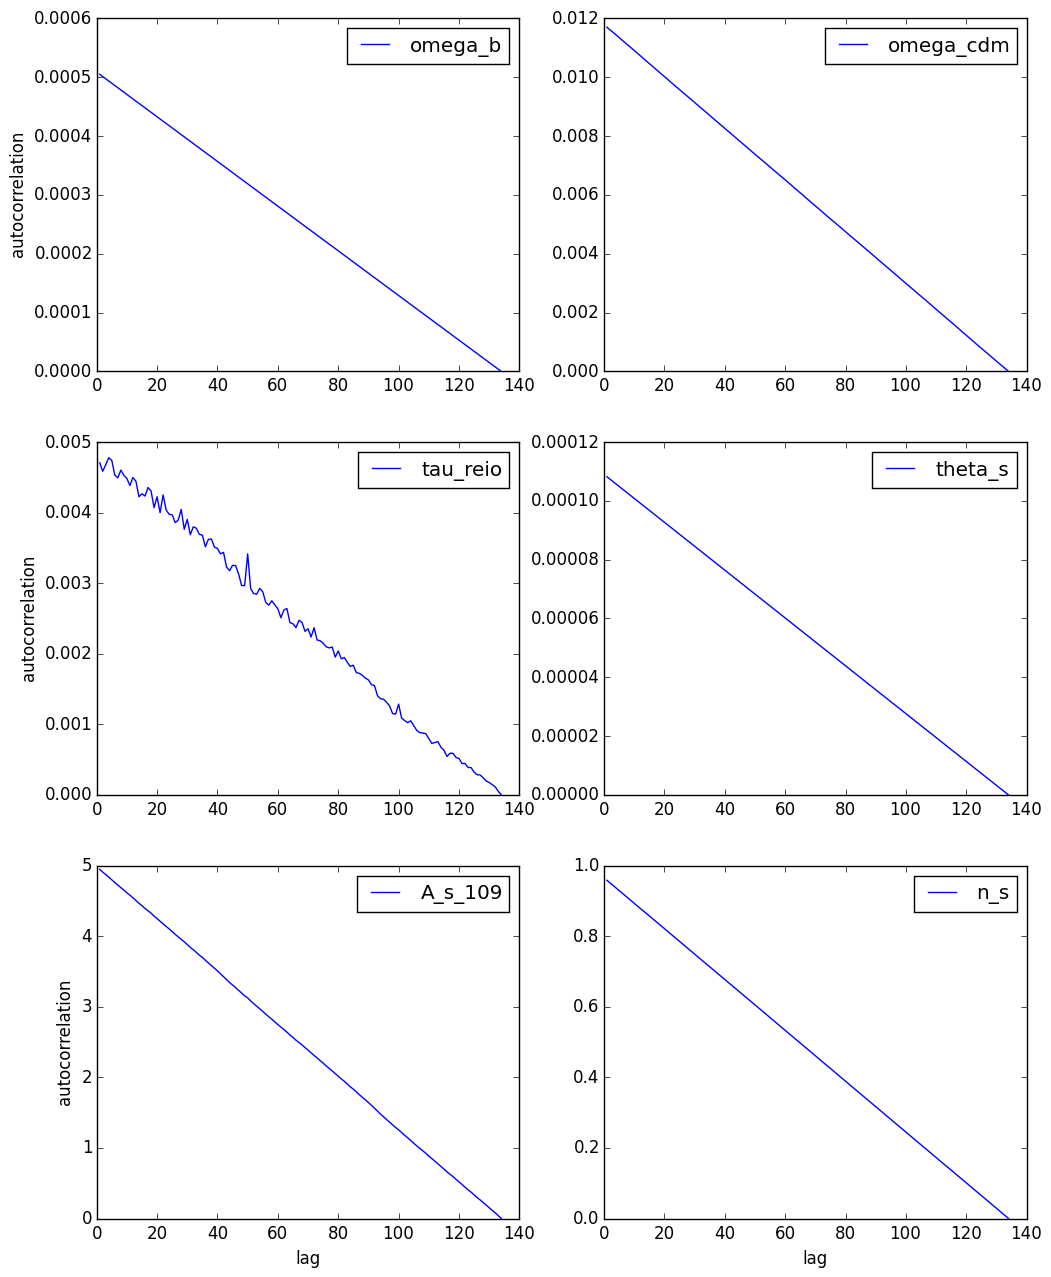

PyObject <matplotlib.legend.Legend object at 0x342f2cbd0>

In [37]:
figure(figsize=(12,15));

i = 1
subplot(3,2,i)
plot(x,Autocorrelation(θChain2[:,i]), label = names_chain[i])
ylabel("autocorrelation")
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain2[:,i]), label = names_chain[i])
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain2[:,i]), label = names_chain[i])
ylabel("autocorrelation")
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain2[:,i]), label = names_chain[i])
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain2[:,i]), label = names_chain[i])
ylabel("autocorrelation")
xlabel("lag")
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain2[:,i]), label = names_chain[i])
xlabel("lag")
legend()

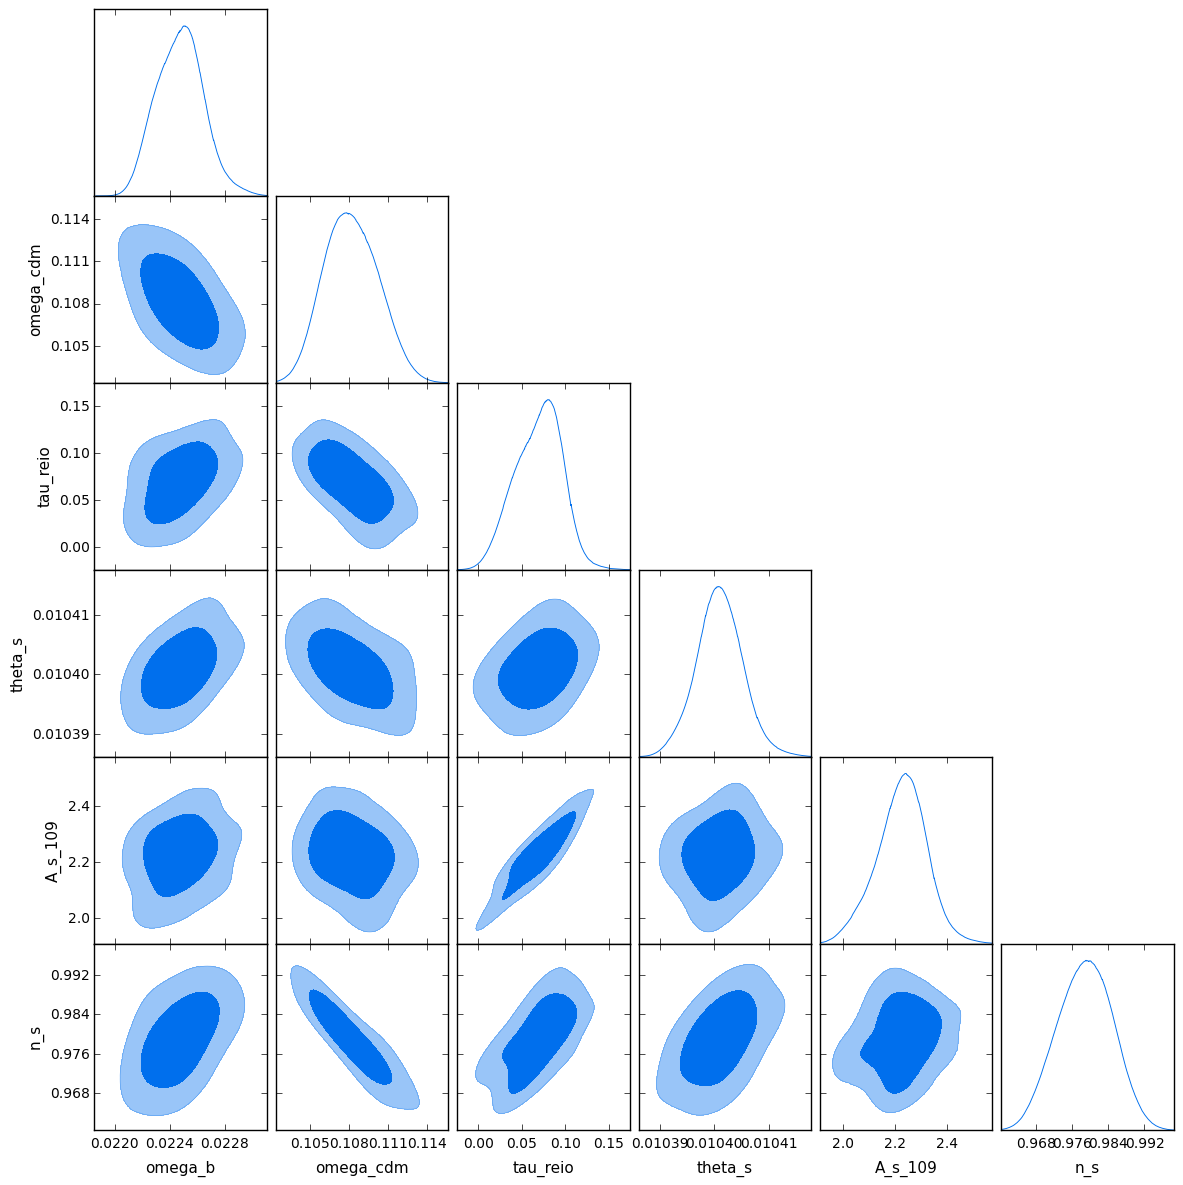

In [38]:
names_chain   = [:omega_b, :omega_cdm, :tau_reio, :theta_s, :A_s_109, :n_s]
full_chain    = θChain2
@pyimport getdist
@pyimport getdist.plots as plots
samples = getdist.MCSamples(samples=full_chain, names=names_chain)
g = plots.getSubplotPlotter()
g[:triangle_plot](samples, filled=true)

Probability Distribution of LCDM params for WMAP, MH chain, and AI chain samples
In this case, MH chain and AI chain have similar distributions because I used the same proposal density when choosing walkers

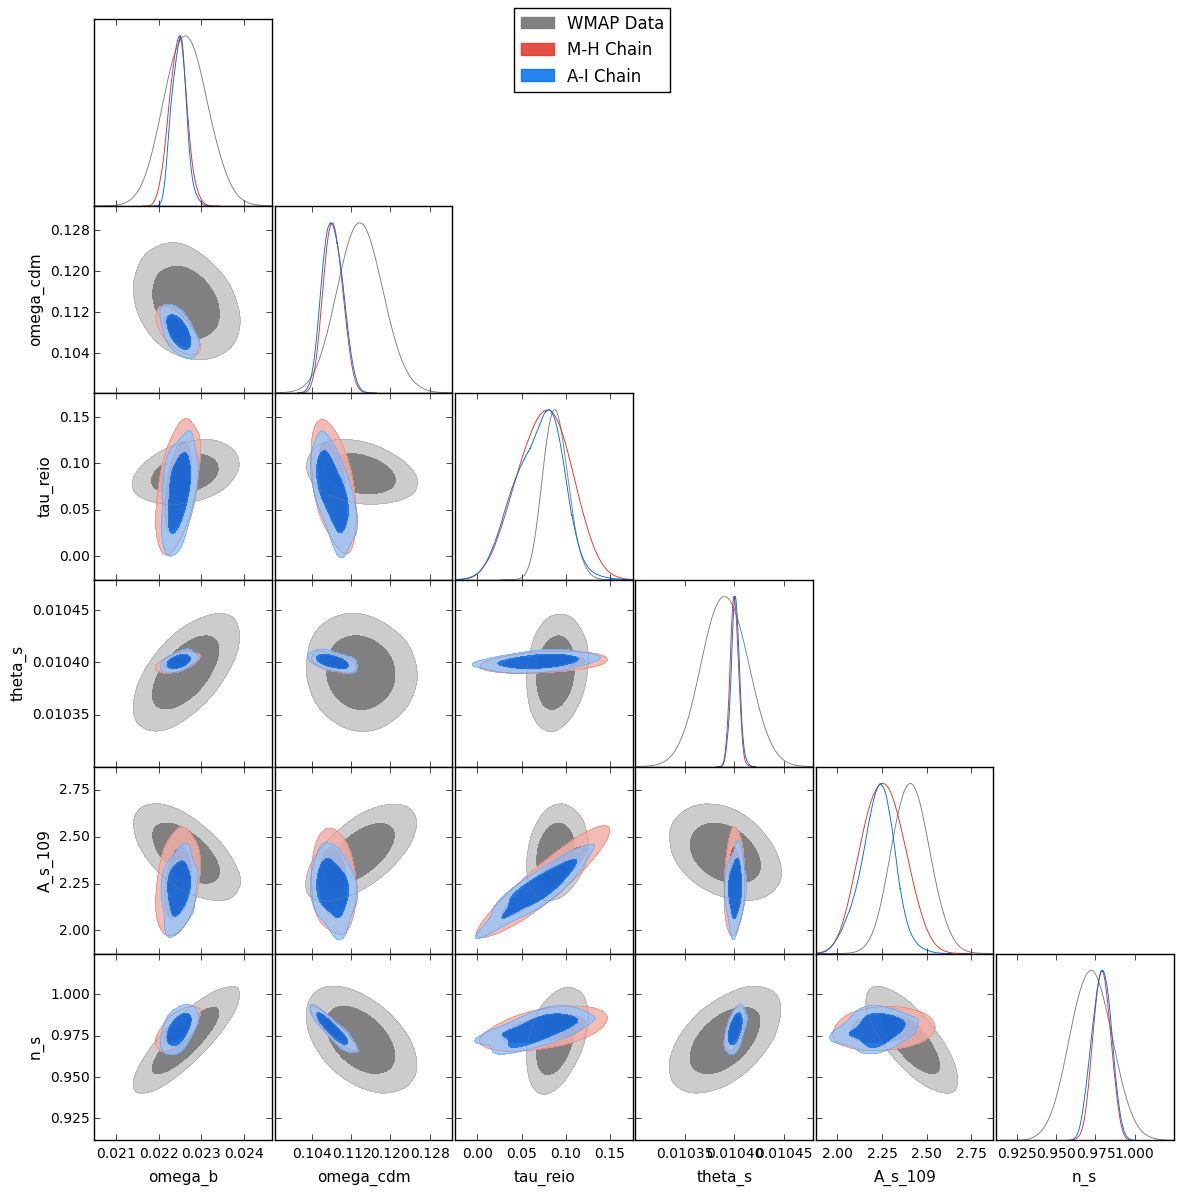

In [39]:
samples0 = getdist.MCSamples(samples=wmap_chain, names=names_chain)
samples1 = getdist.MCSamples(samples=θChain, names=names_chain)
samples2 = getdist.MCSamples(samples=θChain2, names=names_chain)
g = plots.getSubplotPlotter()
g[:triangle_plot]([samples0, samples1, samples2], filled=true, legend_labels = ["WMAP Data", "M-H Chain", "A-I Chain"])